# Контрольная работа
# "Инструментальные средства моделирования"
## Выполнил:
## МАЛЮТИН А.А. БПМ-152

E = 100 ГПа

$\mu$ = 0.1

$t$ = 1 см

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
import scipy.optimize
import scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline

## Построение

In [10]:
def show_parts(*parts, **kwargs):
    plt.figure(figsize=(14,8))
    plt.grid(True)
    plt.axis('equal')
    for part in parts:
        plt.plot(part[:,0],part[:,1], 'o-', c='r')

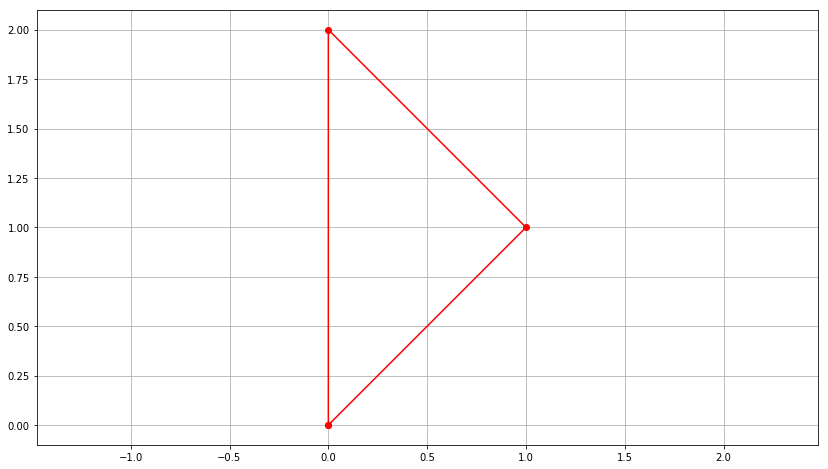

In [158]:
border = np.vstack((split_arc1,split_bbord,split_arc2,split_fbord))

border = np.array([
    [0, 0],
    [1, 1],
    [0, 2],
    [0, 0]
])

show_parts(border)

## Построение триангуляции

In [159]:
inner = np.array([[0.5, 1]])

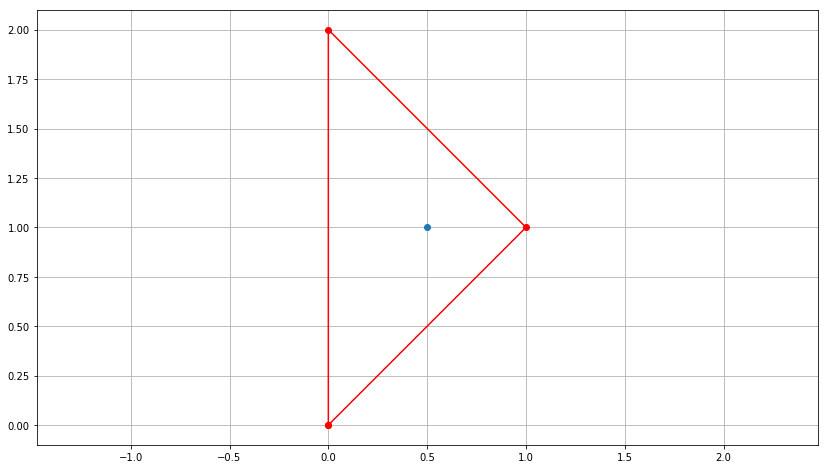

In [160]:
show_parts(border)
plt.plot(inner[:,0],inner[:,1],'o')

In [161]:
Nodes = np.vstack((border[:-1],inner))

In [162]:
Nodes.shape

(4, 2)

In [163]:
trng = scipy.spatial.Delaunay(Nodes)

(-0.05, 1.05, -0.1, 2.1)

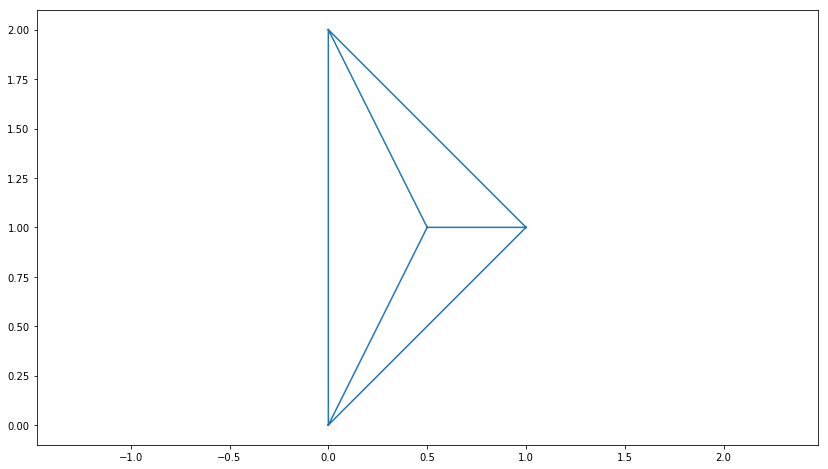

In [164]:
plt.figure(figsize=(14,8))
plt.triplot(Nodes[:,0],Nodes[:,1],trng.simplices.copy())
plt.axis('equal')

In [165]:
trng_vertices = Nodes[trng.simplices]

In [166]:
trng_x_verices = trng_vertices[:,:,0]

In [167]:
trng_y_verices = trng_vertices[:,:,1]

In [168]:
trng_x_mean = np.mean(trng_x_verices,axis=1)
trng_y_mean = np.mean(trng_y_verices,axis=1)

In [169]:
trng_centers = np.hstack((trng_x_mean.reshape(-1,1),trng_y_mean.reshape(-1,1)))

In [170]:
delta2 = 0.01
mask_tri1 = np.sum((trng_centers - np.array([L/2,-H/2+W/2+R]))**2, axis=1) > (R+delta2)**2
mask_tri2 = np.sum((trng_centers - np.array([L/2,-H/2-W/2-R]))**2, axis=1) > (R+delta2)**2

In [171]:
simplices = trng.simplices.copy()
simplices = simplices[mask_tri1 & mask_tri2]

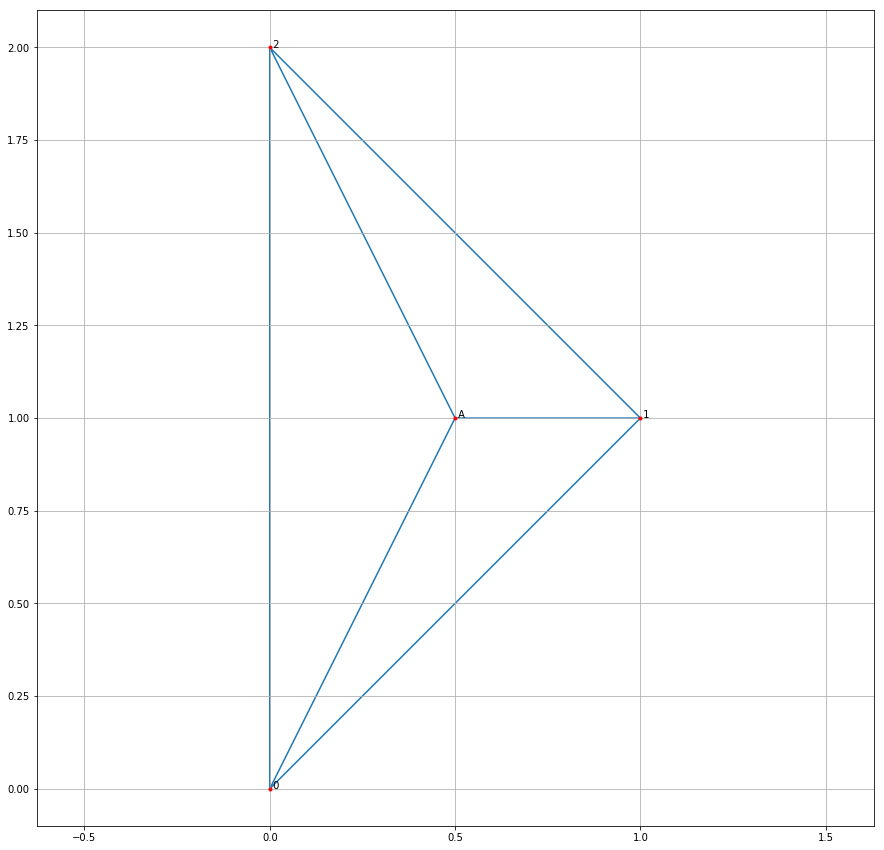

In [172]:
plt.figure(figsize=(15,15))
plt.triplot(Nodes[:,0],Nodes[:,1],simplices)
plt.plot(Nodes[:,0],Nodes[:,1],'.',c='r')
for i, p in enumerate(Nodes[:-1]):
    plt.text(p[0], p[1], ' %d'%i)
    
plt.text(Nodes[-1, 0], Nodes[-1, 1], ' A', withdash=True)
plt.axis('equal')
plt.grid(True)

In [173]:
def triarea(a, b, c):
    ab = b - a
    ac = c - a
    return 0.5 * (ab[:,0]*ac[:,1] - ab[:,1]*ac[:,0])

In [278]:
def FEM(nodes, simplices, e, mu, t, f, fixed_elems):
    # расчет матрицы градиентов
    trng_vertices2 = nodes[simplices] # Пересчитаем, т.к. надо учитывать маски
    A = triarea(trng_vertices2[:,0], trng_vertices2[:,1], trng_vertices2[:,2]) # площади треугольников
    b = trng_vertices2[:, [1,2,0], 1] - trng_vertices2[:, [2, 0, 1], 1]
    c = trng_vertices2[:, [2,0,1], 0] - trng_vertices2[:, [1, 2, 0], 0]
    z = np.zeros_like(b[:,0])
    B1 = np.stack((b[:,0], z, b[:,1], z, b[:,2], z), axis=1)
    B2 = np.stack((z, c[:,0], z, c[:,1], z, c[:,2]), axis=1)
    B3 = np.stack((c[:,0], b[:,0], c[:,1], b[:,1], c[:,2], b[:,2]), axis=1)
    B = np.stack((B1, B2, B3), axis=1) # матрица градиентов
    print(B)
    
    # расчет глобальной матрицы жесткости
    coef = 1/(2*A)
    B *= coef.reshape(-1, 1, 1)
    D = e / (1 - mu**2)*np.array([[1,mu,0], [mu,1,0], [0,0,0.5*(1-mu)]])
    BT = np.transpose(B, axes=(0,2,1))
    Ke = np.matmul(np.matmul(BT, D), B)*t*A.reshape(-1, 1, 1)
    coords0 = simplices[:, 0].reshape(-1, 1)
    coords1 = simplices[:, 1].reshape(-1, 1)
    coords2 = simplices[:, 2].reshape(-1, 1)
    EFT = np.hstack((coords0*2, coords0*2+1, coords1*2, coords1*2+1, coords2*2, coords2*2+1))
    Nn = Nodes.shape[0]
    K = np.zeros((2*Nn, 2*Nn))
    for i in range(simplices.shape[0]):
        K[EFT[i, np.newaxis].T,EFT[i]] += Ke[i]
    dof = np.hstack((fixed_elems*2, fixed_elems*2+1))
    dof = dof[:-1]

    K[dof,:] = 0
    K[:,dof] = 0
    K[dof,dof] = 1
    
    # расчет силы, действующей на элементы
    F = np.zeros(2*Nn)

    F[:-2] = f
    
    F[dof] = 0
    
    # расчет перемещений
    U = np.linalg.solve(K, F)
    
    # расчет напряжений и главных напряжений
    Ue = U[EFT, None] # матрица перемещений
    Eps = np.matmul(B, Ue) # тензор деформаций
    Sig = np.matmul(D, Eps) # тензор напряжений
    NodeA = np.zeros((Nn,1)) 
    NodeSig = np.zeros((Nn,3))
    for i, e in enumerate(simplices):
        NodeSig[e] += Sig[i].T*A[i]
        NodeA[e] += A[i]
    NodeSig /= NodeA
    NodeS1 = 0.5*(NodeSig[:,0]+NodeSig[:,1])+\
         np.sqrt((0.5*(NodeSig[:,0]-NodeSig[:,1]))**2+NodeSig[:,2]**2)
    
    return U, NodeS1

In [279]:
U, NodeS1 = FEM(Nodes,simplices,
                e = 100,
                mu = 0.1,
                t = 1, 
                f = np.array([0, 0, 1, 1, 0, -1]),
                fixed_elems = np.array([0, 2]))

print("dA = ", U.reshape(-1, 2)[-1])
print("sigA = ", NodeS1[-1])

[[[ 1.   0.  -1.   0.   0.   0. ]
  [ 0.  -0.5  0.   1.   0.  -0.5]
  [-0.5  1.   1.  -1.  -0.5  0. ]]

 [[ 2.   0.  -1.   0.  -1.   0. ]
  [ 0.   0.   0.   0.5  0.  -0.5]
  [ 0.   2.   0.5 -1.  -0.5 -1. ]]

 [[ 0.   0.  -1.   0.   1.   0. ]
  [ 0.   0.5  0.  -1.   0.   0.5]
  [ 0.5  0.  -1.  -1.   0.5  1. ]]]
dA =  [5.50000000e-03 8.59728955e-18]
sigA =  1.4142135623730954


In [276]:
def plot_contour_map(Nodes, ResNodes, border, simplices, NodeS1):
    i_max = np.argmax(NodeS1)
    i_min = np.argmin(NodeS1)
    plt.figure(figsize=(8,8))
    levels = np.linspace(NodeS1[i_min], NodeS1[i_max]+0.00001, 5)
    handle = plt.tricontourf(ResNodes[:,0], ResNodes[:, 1], simplices, NodeS1.ravel(), cmap='jet',levels=levels)
    
    plt.tricontour(ResNodes[:, 0], ResNodes[:, 1], simplices, 
                  NodeS1.ravel(), colors='k', levels=levels)
    
    plt.plot(Nodes[:,0],Nodes[:,1],'.',c='r')
    plt.plot(ResNodes[:,0],ResNodes[:,1],'.',c='g')
    plt.plot(border[:,0],border[:,1],'r','-')
    
    plt.plot(ResNodes[i_max,0], ResNodes[i_max,1], '.r')
    plt.text(ResNodes[i_max,0], ResNodes[i_max,1], ' %.2f'%NodeS1[i_max],fontsize=20)
    plt.plot(ResNodes[i_min,0], ResNodes[i_min,1], '.r')
    plt.text(ResNodes[i_min,0], ResNodes[i_min,1], ' %.2f'%NodeS1[i_min],fontsize=20)
    
    cb = plt.gcf().colorbar(handle)
    cb.set_ticks(levels)
    plt.title('Поле главных напряжений в узлах, Н/см$^2$')
    plt.xlabel('X, см')
    plt.ylabel('Y, см')
    plt.axis('equal')
    plt.ylim((-1,3))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


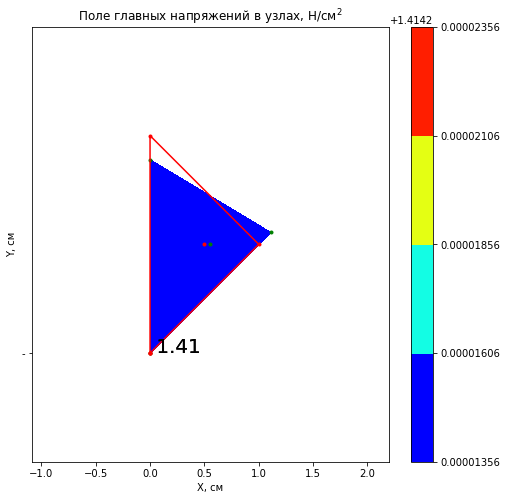

In [277]:
ResNodes = Nodes + 10*U.reshape(-1, 2)

plot_contour_map(Nodes, ResNodes, border, simplices, NodeS1)